# Forecast the  Airlines Passengers data set for 10 years
#dataset:airlines.xlsx

In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6
air = pd.read_excel("C:\\Users\\Raja\\Downloads\\assignments\\forecasting\\airlines.xlsx")

In [2]:
# Showing top 5 records
air.head()

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121


In [3]:
# Setting Month columns as index
air = air.set_index(['Month'])
air.head()

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121


In [4]:
# Showing shape of dataframe i.e. rows x cols
air.shape

(96, 1)

In [5]:
# Checking the total sum of nulls values
air.isnull().sum()

Passengers    0
dtype: int64

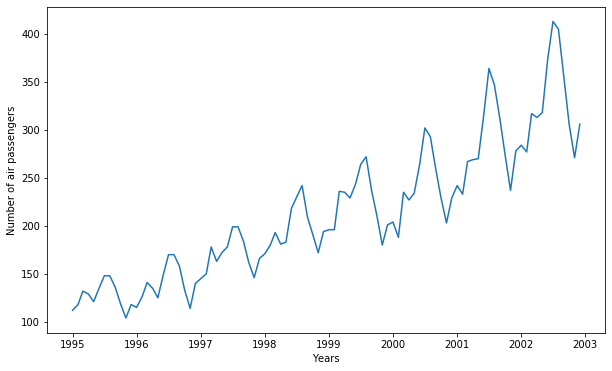

In [6]:
# Ploting the graph (Trend compoenent in th series)
plt.xlabel("Years")
plt.ylabel("Number of air passengers")
plt.plot(air)

### Check for stationarity of the data

In [7]:
#Determing rolling statistics
rolmean = air.rolling(window=12).mean()
rolstd = air.rolling(window=12).std()
print(rolmean, rolstd)

            Passengers
Month                 
1995-01-01         NaN
1995-02-01         NaN
1995-03-01         NaN
1995-04-01         NaN
1995-05-01         NaN
...                ...
2002-08-01  316.833333
2002-09-01  320.416667
2002-10-01  323.083333
2002-11-01  325.916667
2002-12-01  328.250000

[96 rows x 1 columns]             Passengers
Month                 
1995-01-01         NaN
1995-02-01         NaN
1995-03-01         NaN
1995-04-01         NaN
1995-05-01         NaN
...                ...
2002-08-01   54.530781
2002-09-01   55.586883
2002-10-01   53.899668
2002-11-01   49.692616
2002-12-01   47.861780

[96 rows x 1 columns]


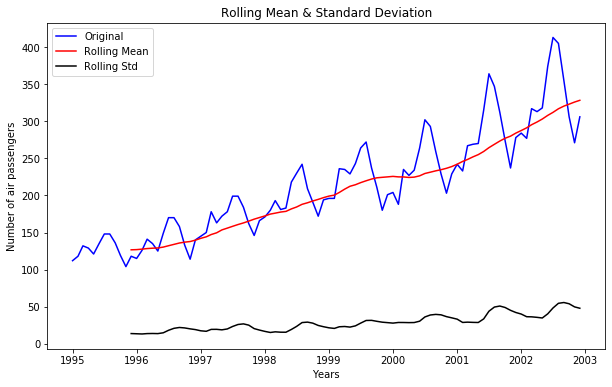

In [8]:
#Plot rolling statistics:(Test of stationarity)
orig = plt.plot(air, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.xlabel("Years")
plt.ylabel("Number of air passengers")
plt.show(block=False)

Showing that rolling mean has a trend component & rolling standard deviation is fairly constant with time. 

In [9]:
# Necessary libraries
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams

In [10]:
#Perform Augmented Dickey–Fuller test:(Test of stationarity)
dftest = adfuller(air['Passengers'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
dfoutput

Test Statistic                  1.340248
p-value                         0.996825
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64

Time Series at the moment is not stationary. p-value nearly 1. 

### Data Transformation to achieve Stationarity
To achieve stationarity:  transform data like taking  log10 , loge , square, square root, cube, cube root, exponential decay, time shift. 

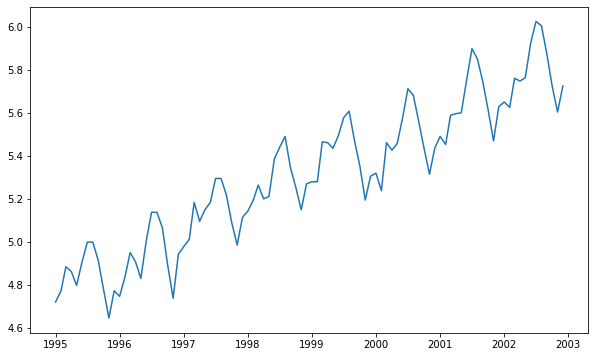

In [11]:
#Log Scale Transformation
# Estimating trend
air_logScale = np.log(air)
plt.plot(air_logScale)

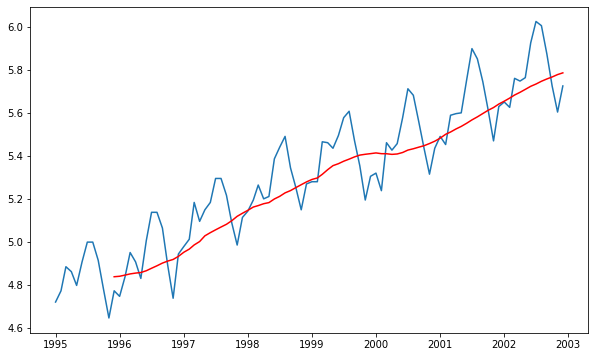

In [12]:
#The below transformation is required to make series stationary
movingAverage = air_logScale.rolling(window=12).mean()
movingSTD = air_logScale.rolling(window=12).std()
plt.plot(air_logScale)
plt.plot(movingAverage, color='red')

In [13]:
# Get the difference between the moving average and the actual number of passengers
differ= air_logScale - movingAverage
differ.head()
#Remove Nan Values
differ.dropna(inplace=True)
differ.head()

,Passengers
Month,
1995-12-01,-0.065494
1996-01-01,-0.093449
1996-02-01,-0.007566
1996-03-01,0.099416
1996-04-01,0.052142


In [14]:
# Declaring funtion TS for stationarity check
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['Passengers'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    dfoutput

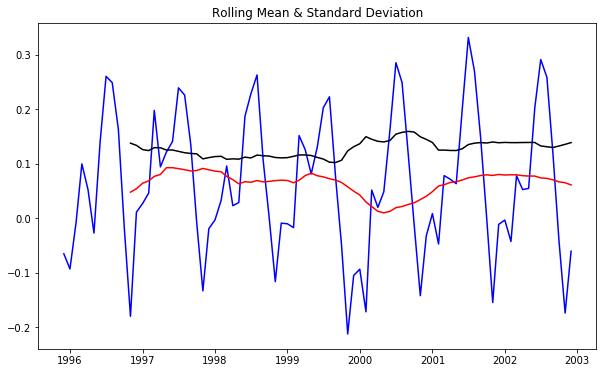

Results of Dickey Fuller Test:


In [15]:
# Test stationarity
test_stationarity(differ)

Graph shows: Subtracting two related series having similar trend components make the result stationary.

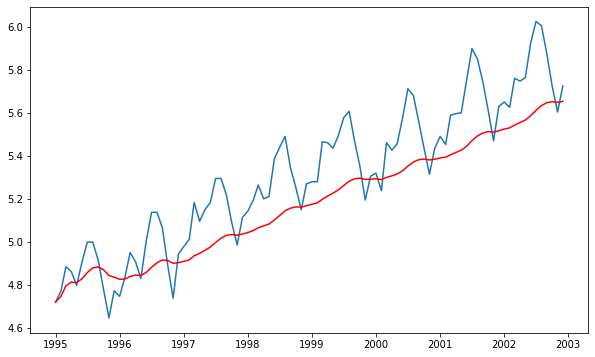

In [16]:
#Exponential Decay Transformation
exponentialDecayWeightedAverage = air_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(air_logScale)
plt.plot(exponentialDecayWeightedAverage, color='red')

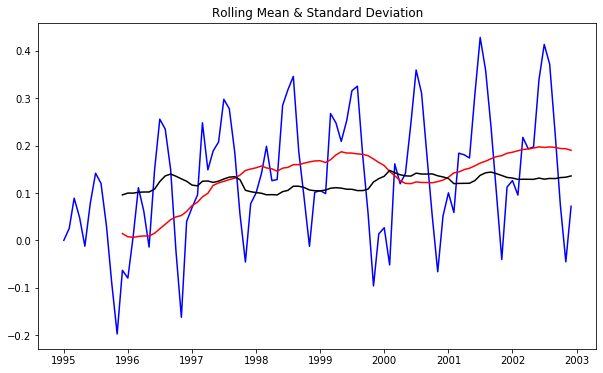

Results of Dickey Fuller Test:


In [17]:
# ADCF test 
datasetLogScaleMinusExponentialMovingAverage = air_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusExponentialMovingAverage)

We observe that the Time Series is stationary & also the series for moving avg & std. dev. is almost parallel to x-axis thus they also have no trend.

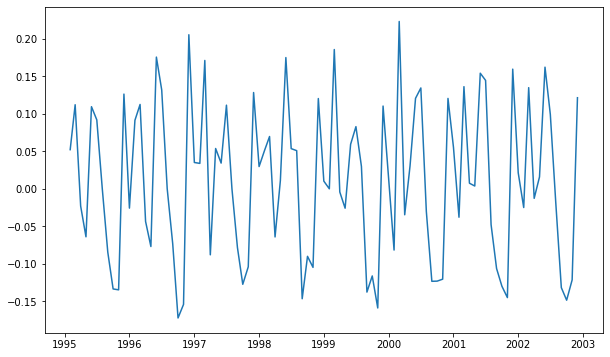

In [18]:
#Time Shift Transformation
datasetLogDiffShifting = air_logScale - air_logScale.shift()
plt.plot(datasetLogDiffShifting)

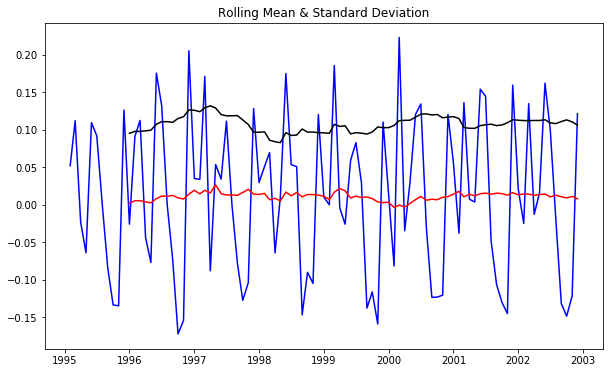

Results of Dickey Fuller Test:


In [19]:
#Time Shift Transformation
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

Visually this is the best result as our series along with rolling statistic values of moving avg & moving std. dev. is very much flat & stationary

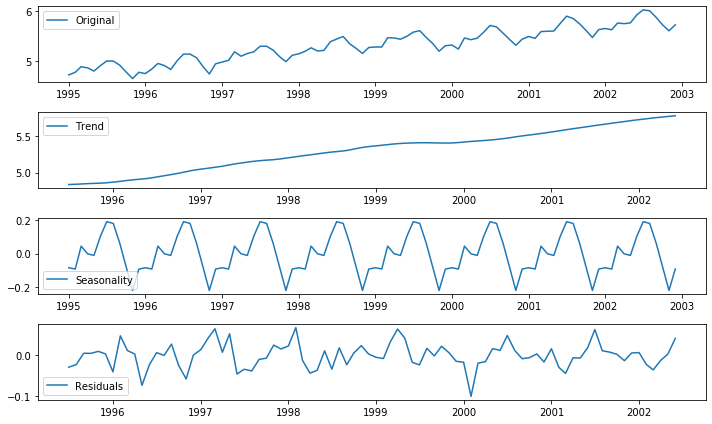

In [20]:
#3 different transformation: log, exp decay & time shift

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(air_logScale)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(air_logScale, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


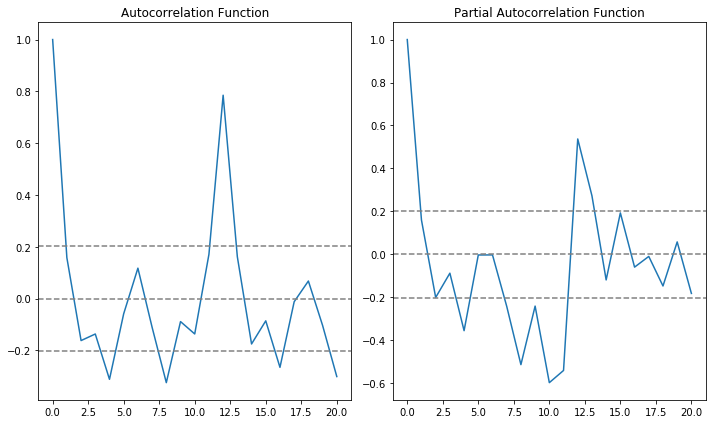

In [21]:
#ACF & PACF plots
lag_acf = acf(datasetLogDiffShifting, nlags=20)
lag_pacf = pacf(datasetLogDiffShifting, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()            


From the ACF graph, we see that curve touches y=0.0 line at x=2. Thus, from theory, Q = 2 From the PACF graph, we see that curve touches y=0.0 line at x=2. Thus, from theory, P = 2

In [22]:
# Restricting showing warnings
import warnings
warnings.filterwarnings('ignore')

Plotting AR model


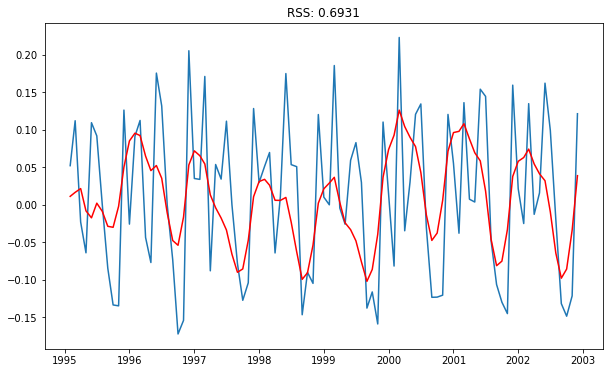

In [23]:
# Building Models
from statsmodels.tsa.arima_model import ARIMA

#AR MODEL
model = ARIMA(air_logScale, order=(2, 1, 2))  
results_AR = model.fit(disp=-1)  
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-datasetLogDiffShifting["Passengers"])**2))
print('Plotting AR model')

Plotting AR model


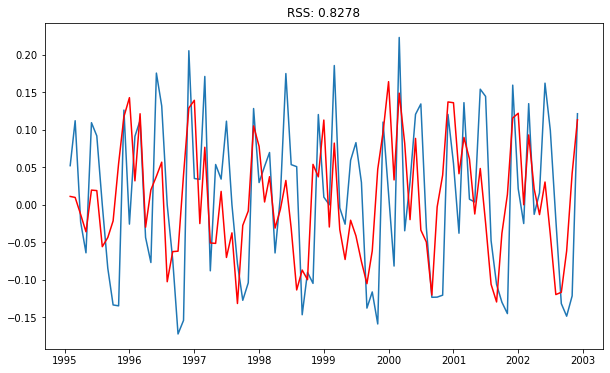

In [24]:
#MA MODEL
model = ARIMA(air_logScale, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(datasetLogDiffShifting)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-datasetLogDiffShifting["Passengers"])**2))
print('Plotting AR model')

Text(0.5, 1.0, 'RSS: 0.6931')

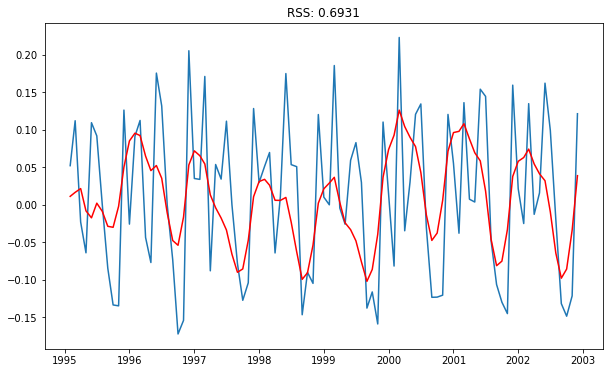

In [25]:
# AR+I+MA = ARIMA model
model = ARIMA(air_logScale, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(datasetLogDiffShifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-datasetLogDiffShifting["Passengers"])**2))

Combining AR & MA into ARIMA indicating to be better than its individual component models.

With the ARIMA model built, we will now generate predictions.

In [26]:
#Prediction & Reverse transformations 
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

Month
1995-02-01    0.011261
1995-03-01    0.016603
1995-04-01    0.021664
1995-05-01   -0.008096
1995-06-01   -0.017396
dtype: float64


In [27]:
#Convert to cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

Month
1995-02-01    0.011261
1995-03-01    0.027864
1995-04-01    0.049528
1995-05-01    0.041431
1995-06-01    0.024035
dtype: float64


In [29]:
#predictions_ARIMA_log 
predictions_ARIMA_log = pd.Series(air_logScale['Passengers'], index=datasetLogDiffShifting['Passengers'].index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
1995-02-01    4.781946
1995-03-01    4.910666
1995-04-01    4.909340
1995-05-01    4.837222
1995-06-01    4.929310
dtype: float64

Text(0.5, 1.0, 'RMSE: nan')

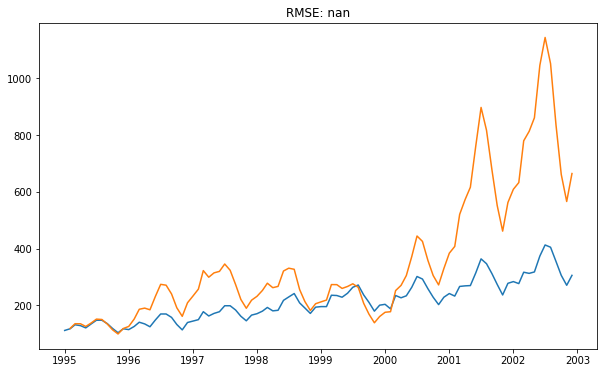

In [30]:
# Inverse of log is exp.
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(air)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-air["Passengers"])**2)/len(air["Passengers"])))

We see that our predicted forecasts are very close to the real time series values indicating a fairly accurate model.

In [31]:
air_logScale

,Passengers
Month,
1995-01-01,4.718499
1995-02-01,4.770685
1995-03-01,4.882802
1995-04-01,4.859812
1995-05-01,4.795791
...,...
2002-08-01,6.003887
2002-09-01,5.872118
2002-10-01,5.723585


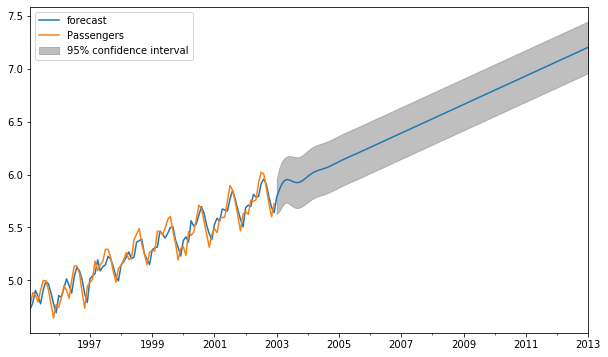

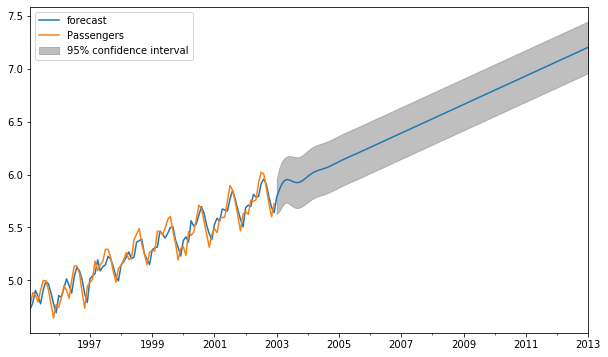

In [32]:
#We have 96(existing data of 8 yrs in months) data points. 
#And we want to forecast for additional 120 data points or 10 yrs.
results_ARIMA.plot_predict(1,216) 

Shaeded portion is confidence level and blue line or curve inside is the 10 years forcasted values.

In [33]:
x=results_ARIMA.forecast(steps=120)
x

(array([5.78999361, 5.8582536 , 5.91203889, 5.94359032, 5.95347926,
        5.94812629, 5.9363895 , 5.92642778, 5.92363277, 5.92990495,
        5.94409989, 5.96319471, 5.98365032, 6.00253694, 6.0181769 ,
        6.03026083, 6.03955198, 6.0473754 , 6.05509381, 6.06371909,
        6.07372944, 6.08508555, 6.09738579, 6.11007865, 6.12265747,
        6.13478851, 6.14635529, 6.1574303 , 6.16820224, 6.17889125,
        6.18967908, 6.20066942, 6.21188086, 6.22326547, 6.23474068,
        6.2462218 , 6.2576461 , 6.26898411, 6.28023853, 6.29143447,
        6.30260626, 6.31378537, 6.32499246, 6.33623466, 6.34750738,
        6.35879885, 6.37009537, 6.38138567, 6.39266334, 6.40392726,
        6.41518044, 6.42642803, 6.43767529, 6.44892611, 6.46018231,
        6.4714437 , 6.48270871, 6.49397521, 6.50524123, 6.51650551,
        6.52776761, 6.53902781, 6.55028685, 6.56154558, 6.5728047 ,
        6.58406461, 6.59532538, 6.60658681, 6.61784859, 6.62911039,
        6.64037196, 6.6516332 , 6.66289411, 6.67